In [76]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# os.environ["WANDB_DISABLED"] = "true"
# os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [77]:
# ! wget https://zenodo.org/record/3628775/files/c-corpus.tar.gz?download=1
# ! tar -xzf "/kaggle/working/c-corpus.tar.gz?download=1"
# ! rm /kaggle/working/c-corpus.tar.gz?download=1

In [78]:
! pip install transformers
! pip install datasets

from transformers import AutoModelForSequenceClassification
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration # RobertaTokenizer

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [79]:
id2label = {0: "CORRECT", 1: "BUGGY"}
label2id = {"CORRECT": 0, "BUGGY": 1}

In [80]:
# tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5-base')
tokenizer = AutoTokenizer.from_pretrained('dipudl/codet5-base')
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

loading file https://huggingface.co/dipudl/codet5-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/ed7e409e6ad247e09a2ca8a19dc9e58d74cb30795f408bcb716cb6756f54b76d.9a35ae57ce66b3a375abfa9a6a2fa53dcd2cd361db8e6478877f08569f69b771
loading file https://huggingface.co/dipudl/codet5-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/1f727ef4e0afebcfcf86fe431abd086875e1d80f1da0e5fc0cc33e4077faf0a9.1c2821a0b9a2f62bbeacf7ba0b4c2b2b4dd6f63645fe6681015af90a376d90a1
loading file https://huggingface.co/dipudl/codet5-base/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/792db69f7307dc6c44be61f902366e9c9ca3d6f8daa189f150e4a407f15a0db0.e2e19d1cfdd164eb1be4cf51c10f0fd5abbc13d2d1ab3839ca28f7dc2e392a87
loading file https://huggingface.co/dipudl/codet5-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/dipudl/codet5-base/resolve/main/special_tokens_map.json from cache at /r

In [81]:
import os

def get_tokenizer_training_corpus():
    total = 0
    for root, dirs, files in os.walk("/kaggle/working/cleaned"):
        for file in files:
            if file.endswith(".c"):
                file_path = os.path.join(root, file)

                with open(file_path, 'rb') as f:
                    content = str(f.read())
                    total += 1
                    if total % 10000 == 0:
                        print(total)
                    yield [content]
                        
#     dataset = train_dataset
#     for start_idx in range(0, len(dataset), 1000):
#         samples = dataset[start_idx : start_idx + 1000]
#         yield samples["full_text"]

In [82]:
tokenizer_training_corpus = get_tokenizer_training_corpus()
tokenizer_training_corpus

<generator object get_tokenizer_training_corpus at 0x7fa224de6050>

In [83]:
# fine_tuned_tokenizer = tokenizer.train_new_from_iterator(tokenizer_training_corpus, vocab_size=20_000)

In [84]:
!pip install huggingface_hub
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token(YOUR_HUGGING_FACE_TOKEN_HERE)"

# from huggingface_hub import notebook_login

# notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [85]:
# fine_tuned_tokenizer.save_pretrained("codet5-base")
# fine_tuned_tokenizer.push_to_hub("codet5-base")

In [86]:
# tokenizer = AutoTokenizer.from_pretrained('dipudl/codet5-base')

## Training

In [87]:
df = pd.read_csv("/kaggle/input/function-swap-samples-178k/function_swap_samples.txt", sep="\t")

In [88]:
df

,function_name,arg1,arg2,arg_type,param1,param2,labels
0,__builtin_bfin_compose_2x16,0x3000,0x2000,int,NaN,NaN,0
1,__builtin_bfin_compose_2x16,0x2000,0x3000,int,NaN,NaN,1
2,__builtin_bfin_compose_2x16,0x7000,0x5000,int,NaN,NaN,0
3,__builtin_bfin_compose_2x16,0x5000,0x7000,int,NaN,NaN,1
4,foo0000,a,b,fract2x16,a,b,0
...,...,...,...,...,...,...,...
178275,strstr,libname,package:,char *,__haystack,__needle,0
178276,strstr,package:,libname,char *,__haystack,__needle,1
178277,fopen,fn,w,FILE *,__filename,__modes,0
178278,fopen,w,fn,FILE *,__filename,__modes,1


In [89]:
df.drop_duplicates(ignore_index=True, inplace=True)

In [90]:
df

,function_name,arg1,arg2,arg_type,param1,param2,labels
0,__builtin_bfin_compose_2x16,0x3000,0x2000,int,NaN,NaN,0
1,__builtin_bfin_compose_2x16,0x2000,0x3000,int,NaN,NaN,1
2,__builtin_bfin_compose_2x16,0x7000,0x5000,int,NaN,NaN,0
3,__builtin_bfin_compose_2x16,0x5000,0x7000,int,NaN,NaN,1
4,foo0000,a,b,fract2x16,a,b,0
...,...,...,...,...,...,...,...
83839,REprintf,rep,VimCom Sent: %s\n,int,NaN,NaN,1
83840,strcmp,name,table,int,__s1,__s2,0
83841,strcmp,table,name,int,__s1,__s2,1
83842,fopen,.live,w,FILE *,__filename,__modes,0


In [91]:
df.isna().sum()

function_name      288
arg1               520
arg2               520
arg_type             0
param1           52284
param2           52276
labels               0
dtype: int64

In [92]:
# df['function_name'] = df['function_name'].fillna('[UNK]')
# df['arg1']=df['arg1'].fillna('[UNK]')
# df['arg2']=df['arg2'].fillna('[UNK]')
# df['arg_type']=df['arg_type'].fillna('[UNK]')
# df['param1']=df['param1'].fillna('[UNK]')
# df['param2']=df['param2'].fillna('[UNK]')

df['function_name'] = df['function_name'].fillna('')
df['arg1']=df['arg1'].fillna('')
df['arg2']=df['arg2'].fillna('')
df['arg_type']=df['arg_type'].fillna('')
df['param1']=df['param1'].fillna('')
df['param2']=df['param2'].fillna('')

In [93]:
df.isna().sum()

function_name    0
arg1             0
arg2             0
arg_type         0
param1           0
param2           0
labels           0
dtype: int64

In [94]:
df['full_text'] = df['function_name'] + ' [SEP] '+ df['arg1'] + ' [SEP] '+ df['arg2'] + ' [SEP] '+ df['arg_type'] + ' [SEP] '+ df['param1'] + ' [SEP] ' + df['param2']
# df['full_text'] = df['function_name'] + ' '+ df['arg1'] + ' '+ df['arg2'] + ' '+ df['arg_type'] + ' '+ df['param1'] + ' ' + df['param2']

In [95]:
df.drop(['function_name','arg1','arg2','arg_type','param1','param2'],axis=1,inplace=True)

In [96]:
df

,labels,full_text
0,0,__builtin_bfin_compose_2x16 [SEP] 0x3000 [SEP]...
1,1,__builtin_bfin_compose_2x16 [SEP] 0x2000 [SEP]...
2,0,__builtin_bfin_compose_2x16 [SEP] 0x7000 [SEP]...
3,1,__builtin_bfin_compose_2x16 [SEP] 0x5000 [SEP]...
4,0,foo0000 [SEP] a [SEP] b [SEP] fract2x16 [SEP] ...
...,...,...
83839,1,REprintf [SEP] rep [SEP] VimCom Sent: %s\n [SE...
83840,0,strcmp [SEP] name [SEP] table [SEP] int [SEP] ...
83841,1,strcmp [SEP] table [SEP] name [SEP] int [SEP] ...
83842,0,fopen [SEP] .live [SEP] w [SEP] FILE * [SEP] _...


In [97]:
def tokenize_text(examples):
    return tokenizer(examples["full_text"], truncation=True, max_length=100, padding=True)

In [98]:
df = df.sample(frac = 1) # shuffling the dataset
df.reset_index(drop=True,inplace=True)
df

,labels,full_text
0,1,PsychMatch [SEP] TextEncodingLocale [SEP] pref...
1,1,strcasecmp [SEP] name_type [SEP] hostbased-ser...
2,1,strcmp [SEP] FUNSMRY [SEP] ext [SEP] int [SEP]...
3,1,strstr [SEP] .c [SEP] output_file_name [SEP] c...
4,0,gg_fopen [SEP] buf [SEP] w [SEP] FILE * [SEP] ...
...,...,...
83839,1,"test [SEP] domain.com [SEP] example.com, *.dom..."
83840,0,strcmp [SEP] * [SEP] -descert [SEP] int [SEP] ...
83841,0,strcasecmp [SEP] in [SEP] q931 [SEP] int [SEP]...
83842,0,__builtin_isunordered [SEP] __builtin_nan [SEP...


In [99]:
df_train, df_test = train_test_split(df, test_size=0.1)

In [100]:
df_train

,labels,full_text
80345,1,damroll [SEP] 4 [SEP] 10 [SEP] int [SEP] [SEP]
47067,0,hp3800_calibtransparent [SEP] option [SEP] def...
81877,1,strpbrk [SEP] \t [SEP] newname [SEP] char * [...
3875,0,warning [SEP] 152 [SEP] n [SEP] int [SEP] [SEP]
47722,1,dssp_error_message [SEP] strerror [SEP] error ...
...,...,...
82752,1,strcmp [SEP] request [SEP] type [SEP] int [SEP...
68946,0,[SEP] f [SEP] a [SEP] <dependent type> [SEP] ...
73026,1,_rl_rubout_char [SEP] key [SEP] count [SEP] in...
34722,0,die [SEP] invalid log-grep regex: %s [SEP] err...


In [101]:
df_test

,labels,full_text
77154,1,strcmp [SEP] default [SEP] s [SEP] int [SEP] _...
17991,1,TIFFError [SEP] Wrong image parameters; can't ...
15317,1,__builtin_atan2f [SEP] 0.0 [SEP] - [SEP] float...
69119,0,printf [SEP] subfile %s not found\n [SEP] subf...
50626,1,strcmpi [SEP] nobranch [SEP] flag [SEP] int [S...
...,...,...
1450,0,dup2 [SEP] ofd [SEP] 1 [SEP] int [SEP] __fd [S...
40712,0,printf [SEP] %s [SEP] hdr [SEP] int [SEP] [SEP]
68569,1,w_timeval_compare [SEP] file [SEP] since [SEP]...
67414,1,strcmp [SEP] action [SEP] param [SEP] int [SEP...


In [102]:
train_dataset = Dataset.from_pandas(df_train)
train_dataset

Dataset({
    features: ['labels', 'full_text', '__index_level_0__'],
    num_rows: 75459
})

In [103]:
test_dataset = Dataset.from_pandas(df_test)
test_dataset

Dataset({
    features: ['labels', 'full_text', '__index_level_0__'],
    num_rows: 8385
})

In [104]:
train_dataset = train_dataset.map(tokenize_text, batched=True, drop_last_batch=True, remove_columns=["full_text", "__index_level_0__"])
train_dataset

  0%|          | 0/75 [00:00<?, ?ba/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 75000
})

In [105]:
test_dataset = test_dataset.map(tokenize_text, batched=True, drop_last_batch=True, remove_columns=["full_text", "__index_level_0__"])
test_dataset

  0%|          | 0/8 [00:00<?, ?ba/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 8000
})

In [106]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {"accuracy": accuracy, "f1": f1}

In [107]:
train_dataset = train_dataset.train_test_split(test_size=0.1)
train_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 67500
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 7500
    })
})

In [108]:
from transformers import TrainingArguments

batch_size = 32

logging_steps = len(train_dataset["train"]) // batch_size
output_dir = "function-arg-swap-model"
training_args = TrainingArguments(output_dir,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy="epoch",
                                  logging_steps=logging_steps,
                                  save_strategy="epoch",
                                  # save_steps=10000,
                                  # fp16=True,
                                  push_to_hub=False,
                                  report_to="wandb"
                                )

PyTorch: setting up devices


In [109]:
from transformers import Trainer, DefaultDataCollator

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset["train"],         
    eval_dataset=train_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [110]:
history = trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 67500
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 10550
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.517919,0.722133,0.698844
2,0.550700,0.368466,0.811733,0.795836
3,0.550700,0.326795,0.834533,0.833400
4,0.322800,0.334577,0.848133,0.845013
5,0.322800,0.306111,0.854933,0.849474
6,0.248700,0.298890,0.864667,0.864214
7,0.248700,0.297035,0.874800,0.875415
8,0.207200,0.290025,0.875467,0.874866
9,0.207200,0.292785,0.875600,0.874715
10,0.180300,0.305205,0.878133,0.877611


***** Running Evaluation *****
  Num examples = 7500
  Batch size = 64
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 7500
  Batch size = 64
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 7500
  Batch size = 64
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gath

In [124]:
trainer.save_model("codet5-87.7f1-10ep")

Saving model checkpoint to codet5-87.7f1-10ep
Configuration saved in codet5-87.7f1-10ep/config.json
Model weights saved in codet5-87.7f1-10ep/pytorch_model.bin
tokenizer config file saved in codet5-87.7f1-10ep/tokenizer_config.json
Special tokens file saved in codet5-87.7f1-10ep/special_tokens_map.json


-----
## Testing
-----

In [112]:
prediction = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8000
  Batch size = 64
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [142]:
prediction

PredictionOutput(predictions=array([[-1.5262053 ,  1.555742  ],
       [-3.6396356 ,  3.778317  ],
       [ 0.31872478, -0.5065445 ],
       ...,
       [ 0.45182976, -0.59455925],
       [-3.956964  ,  4.152476  ],
       [ 3.6027818 , -3.866059  ]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 1, 0]), metrics={'test_loss': 0.3309861123561859, 'test_accuracy': 0.868875, 'test_f1': 0.8716819571865444, 'test_runtime': 13.7994, 'test_samples_per_second': 579.735, 'test_steps_per_second': 9.058})

In [144]:
predictions, labels, _ = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 8000
  Batch size = 64
/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [145]:
predictions = np.argmax(predictions, axis=1)
predictions

array([1, 1, 0, ..., 0, 1, 0])

In [146]:
f1_score(predictions, test_dataset["labels"])

0.8716819571865444

In [148]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix: \n", confusion_matrix(predictions, test_dataset["labels"]))

Confusion Matrix: 
 [[3388  519]
 [ 530 3563]]


<Figure size 720x576 with 0 Axes>

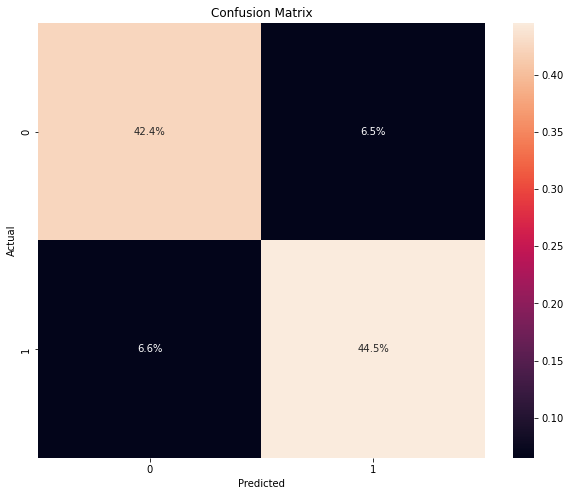

In [159]:
# Import the required libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Data
a = [[3388,519],
 [530,3563]]

# Select Confusion Matrix Size
plt.figure(figsize = (10,8))

# Select Confusion Matrix Size
plt.figure(figsize = (10,8))

# Create Confusion Matrix and show percentages
b = sns.heatmap(a/np.sum(a), annot=True, fmt='.1%')

# Set the Title
b.set(title='Confusion Matrix')

# Set the Labels
b.set(xlabel='Predicted', ylabel='Actual')

# Display the Confusion Matrix
plt.show()

-----
## Inference
-----

In [123]:
! ls /kaggle/working/function-arg-swap-model

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
checkpoint-10000


In [ ]:
train